#### Introduction

Credit card default prediction is a fundamental problem in financial risk management. Banks and lending institutions must assess whether a customer is likely to default on their upcoming payment cycle, as misjudging credit risk can lead to significant financial losses. Traditional credit scoring methods—such as logistic regression and manual rule-based systems, often struggle to capture non-linear patterns in customer behavior and may not fully exploit the rich historical data available.

In this project, we develop and evaluate machine learning models to predict the default payment next month using the well-known UCI “Default of Credit Card Clients” dataset. The dataset includes demographic variables, credit limits, repayment history, billing amounts and payment behavior over six months for 30,000 credit card customers. The task is a binary classification problem with notable class imbalance (~78% non-default, 22% default).

Prior research (Yeh & Lien, 2009; Wahab et al., 2024; Bhandary & Ghosh, 2025) demonstrates that both classical models and modern ensemble or neural architectures can perform well on this dataset, with more complex models often achieving higher AUC and F1 scores. However, logistic regression remains important in real financial applications due to its interpretability and explainability requirements under regulatory guidelines.

Our notebook follows a structured ML workflow:

- Data exploration and preprocessing

- Feature encoding and standardization

- Training baseline models (Logistic Regression, Decision Tree, SVM)

- Evaluating performance using Accuracy, Precision, Recall, F1, and AUC

- Exploring ensemble methods such as Random Forest, Soft- Voting Classifiers

- Comparing model performance to identify which approach best predicts default

The goal is not only to achieve strong predictive performance but also to understand which features influence default behavior, how different models compare, and how machine learning can support real-world credit risk assessment.


### Importing Libraries


In [53]:
# imoport necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             confusion_matrix, roc_auc_score, roc_curve , auc
                             )


## Step 1: Load and Explore the Dataset


In [29]:
df = pd.read_excel("default of credit card clients.xls", header=1)

print("Dataset Shape:", df.shape)
print("\nFirst 5 rows:")
display(df.head())

print("\nDataset Info:")
df.info()

Dataset Shape: (30000, 25)

First 5 rows:


,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0



Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype
---  ------                      --------------  -----
 0   ID                          30000 non-null  int64
 1   LIMIT_BAL                   30000 non-null  int64
 2   SEX                         30000 non-null  int64
 3   EDUCATION                   30000 non-null  int64
 4   MARRIAGE                    30000 non-null  int64
 5   AGE                         30000 non-null  int64
 6   PAY_0                       30000 non-null  int64
 7   PAY_2                       30000 non-null  int64
 8   PAY_3                       30000 non-null  int64
 9   PAY_4                       30000 non-null  int64
 10  PAY_5                       30000 non-null  int64
 11  PAY_6                       30000 non-null  int64
 12  BILL_AMT1                   30000 non-null  int64
 13  BILL_AMT2                   30000 non-null  in

In [30]:
# Create a copy of the original dataset
data = df.copy()

In [31]:
# drop 'ID' column as it is not needed for analysis
df = df.drop(columns=['ID'])

## Step 2: Initial Data Analysis

Check for missing values and examine class distribution.


In [32]:
# Check for missing values
print("Missing values per column:")
print(df.isna().sum())
print()
# Check for duplicates
print("Number of duplicate rows:", df.duplicated().sum())

# Check class distribution (imbalance)
print("Class Distribution:")
print(df['default payment next month'].value_counts())
print("\nClass Proportions:")
print(df['default payment next month'].value_counts(normalize=True))

Missing values per column:
LIMIT_BAL                     0
SEX                           0
EDUCATION                     0
MARRIAGE                      0
AGE                           0
PAY_0                         0
PAY_2                         0
PAY_3                         0
PAY_4                         0
PAY_5                         0
PAY_6                         0
BILL_AMT1                     0
BILL_AMT2                     0
BILL_AMT3                     0
BILL_AMT4                     0
BILL_AMT5                     0
BILL_AMT6                     0
PAY_AMT1                      0
PAY_AMT2                      0
PAY_AMT3                      0
PAY_AMT4                      0
PAY_AMT5                      0
PAY_AMT6                      0
default payment next month    0
dtype: int64

Number of duplicate rows: 35
Class Distribution:
0    23364
1     6636
Name: default payment next month, dtype: int64

Class Proportions:
0    0.7788
1    0.2212
Name: default payment next mo

- There are no missing values in the Dataset.


- There were 35 duplicates after removing ID column


In [33]:
# Remove duplicate rows
df = df.drop_duplicates()

# Verify duplicates are removed
print("Number of duplicate rows after removal:", df.duplicated().sum())
print("New shape:", df.shape)

Number of duplicate rows after removal: 0
New shape: (29965, 24)


In [34]:
print(df['default payment next month'].value_counts())

0    23335
1     6630
Name: default payment next month, dtype: int64


## Step 3: Split Data into Train/Test Sets

**CRITICAL:** We split BEFORE any preprocessing to prevent data leakage.

- Train: 80%
- Test: 20%


In [35]:
# Prepare features and target
X = df.drop('default payment next month', axis=1)
y = df['default payment next month']

# Split: Train 80%, Test 20% 
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train set size:", X_train.shape)
print("Test set size:", X_test.shape)

# Verify class distribution is maintained
print("\nClass distribution in train set:")
print(y_train.value_counts(normalize=True))
print("\nClass distribution in test set:")
print(y_test.value_counts(normalize=True))

Train set size: (23972, 23)
Test set size: (5993, 23)

Class distribution in train set:
0    0.778742
1    0.221258
Name: default payment next month, dtype: float64

Class distribution in test set:
0    0.778742
1    0.221258
Name: default payment next month, dtype: float64


## Step 4: Encode Categorical Variables

**Categorical Variables:**

- EDUCATION: ordinal encoding
- MARRIAGE: One-hot encoding


In [36]:
# uniquen values in 'MARRRIAGE' column
print("\nUnique values in 'MARRIAGE' column before cleaning:", df['MARRIAGE'].unique())


Unique values in 'MARRIAGE' column before cleaning: [1 2 3 0]


In [37]:
print(X_train.columns)

Index(['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2',
       'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6'],
      dtype='object')


In [38]:
# ORDINAL + OHE ENCODING

print("Columns before encoding:", X_train.columns.tolist())

### 1. Ordinal encoding of 'EDUCATION' column

education_map = {
    1: 3,   # graduate school
    2: 2,   # university
    3: 1,   # high school
    4: 0,   # others
    5: 0,   # unknown
    6: 0,   # unknown
    0: 0    # some datasets include 0 erroneously
}

X_train["EDUCATION"] = X_train["EDUCATION"].map(education_map)
X_test["EDUCATION"]  = X_test["EDUCATION"].map(education_map)

### 

# Only encode if column exists
if "MARRIAGE" in X_train.columns:
    X_train = pd.get_dummies(X_train, columns=["MARRIAGE"], drop_first=True)
    X_test  = pd.get_dummies(X_test,  columns=["MARRIAGE"], drop_first=True)

# Align columns (important)
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

print("\nAfter encoding:")
print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

print("\nSample rows after encoding:")
print(X_train.head())


Columns before encoding: ['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']

After encoding:
Train shape: (23972, 25)
Test shape: (5993, 25)

Sample rows after encoding:
       LIMIT_BAL  SEX  EDUCATION  AGE  PAY_0  PAY_2  PAY_3  PAY_4  PAY_5  \
27420     300000    1          2   35     -2     -2     -2     -2     -2   
15350      50000    2          1   37      2      2      2      2      2   
26641      80000    1          3   23     -1     -1     -1     -1      0   
21618      50000    2          2   26     -1     -1     -1     -1     -1   
11570     200000    1          2   30     -2     -2     -2     -2     -2   

       PAY_6  ...  BILL_AMT6  PAY_AMT1  PAY_AMT2  PAY_AMT3  PAY_AMT4  \
27420     -2  ...          0         0         0         0         0   
15350      2  ...      

## Step 5: Standardize Numerical Features

**Important:** We fit the scaler ONLY on training data, then transform all sets.
This prevents data leakage from test sets.


In [39]:
# Initialize scaler
scaler = StandardScaler()

# Identify numerical columns (exclude binary/dummy variables)
numerical_features = X_train.select_dtypes(include=['int64','float64']).columns
# Exclude dummy variables (one-hot encoded MARRIAGE columns)
numerical_features = [
    col for col in numerical_features
    if not col.startswith("MARRIAGE_")
]

print(f"Scaling {len(numerical_features)} numerical features")

# Fit scaler on training data
scaler.fit(X_train[numerical_features])

# Transform all sets using the fitted scaler
X_train[numerical_features] = scaler.transform(X_train[numerical_features])
X_test[numerical_features] = scaler.transform(X_test[numerical_features])

print("✓ Preprocessing complete!")
print("\nSample of scaled features:")
print(X_train[numerical_features].head())

Scaling 22 numerical features
✓ Preprocessing complete!

Sample of scaled features:
       LIMIT_BAL      SEX  EDUCATION       AGE     PAY_0     PAY_2     PAY_3  \
27420   1.022024 -1.22974  -0.215889 -0.050264 -1.771947 -1.566494 -1.544266   
15350  -0.903020  0.81318  -1.561518  0.167213  1.793738  1.781057  1.818359   
26641  -0.672015 -1.22974   1.129740 -1.355126 -0.880526 -0.729606 -0.703609   
21618  -0.903020  0.81318  -0.215889 -1.028910 -0.880526 -0.729606 -0.703609   
11570   0.252006 -1.22974  -0.215889 -0.593956 -1.771947 -1.566494 -1.544266   

          PAY_4     PAY_5     PAY_6  ...  BILL_AMT3  BILL_AMT4  BILL_AMT5  \
27420 -1.530037 -1.538794 -1.492534  ...  -0.678531  -0.674057  -0.665085   
15350  1.906811  2.010259  2.005012  ...   0.032115   0.072324  -0.220084   
26641 -0.670825  0.235732  0.256239  ...  -0.672134  -0.660258  -0.650460   
21618 -0.670825 -0.651531 -0.618147  ...  -0.672912  -0.667997  -0.665085   
11570 -1.530037 -1.538794 -1.492534  ...  -0.32190

## STEP 6: Calculating Feature importance


In [40]:
# Stage 1: Train models for feature importance analysis
log_reg = LogisticRegression(max_iter=1000, random_state=100, class_weight='balanced')
rf_clf = RandomForestClassifier(n_estimators=100, random_state=100, class_weight='balanced')

log_reg.fit(X_train, y_train)
rf_clf.fit(X_train, y_train)
print("✓ LR and RF trained for feature importance analysis")

✓ LR and RF trained for feature importance analysis


LOGISTIC REGRESSION - Top 20 Features
MARRIAGE_1    0.769040
MARRIAGE_3    0.713476
MARRIAGE_2    0.582764
PAY_0         0.578471
BILL_AMT1     0.423640
BILL_AMT2     0.269488
PAY_AMT1      0.243578
PAY_AMT2      0.163753
PAY_2         0.120436
LIMIT_BAL     0.107080
PAY_AMT4      0.088522
EDUCATION     0.082058
PAY_3         0.077464
AGE           0.056716
BILL_AMT5     0.053729
SEX           0.049326
PAY_AMT5      0.046075
BILL_AMT6     0.037927
PAY_AMT6      0.033433
PAY_4         0.028948
dtype: float64

RANDOM FOREST - Top 20 Features
PAY_0        0.098480
BILL_AMT1    0.062196
AGE          0.061614
LIMIT_BAL    0.060818
PAY_AMT1     0.052755
BILL_AMT2    0.051997
PAY_AMT3     0.050092
PAY_AMT2     0.049984
BILL_AMT3    0.049406
BILL_AMT6    0.048256
BILL_AMT4    0.048196
BILL_AMT5    0.048130
PAY_AMT4     0.046300
PAY_AMT6     0.046144
PAY_2        0.044645
PAY_AMT5     0.044236
PAY_3        0.034964
EDUCATION    0.019973
PAY_5        0.019328
PAY_4        0.018895
dtype: float64

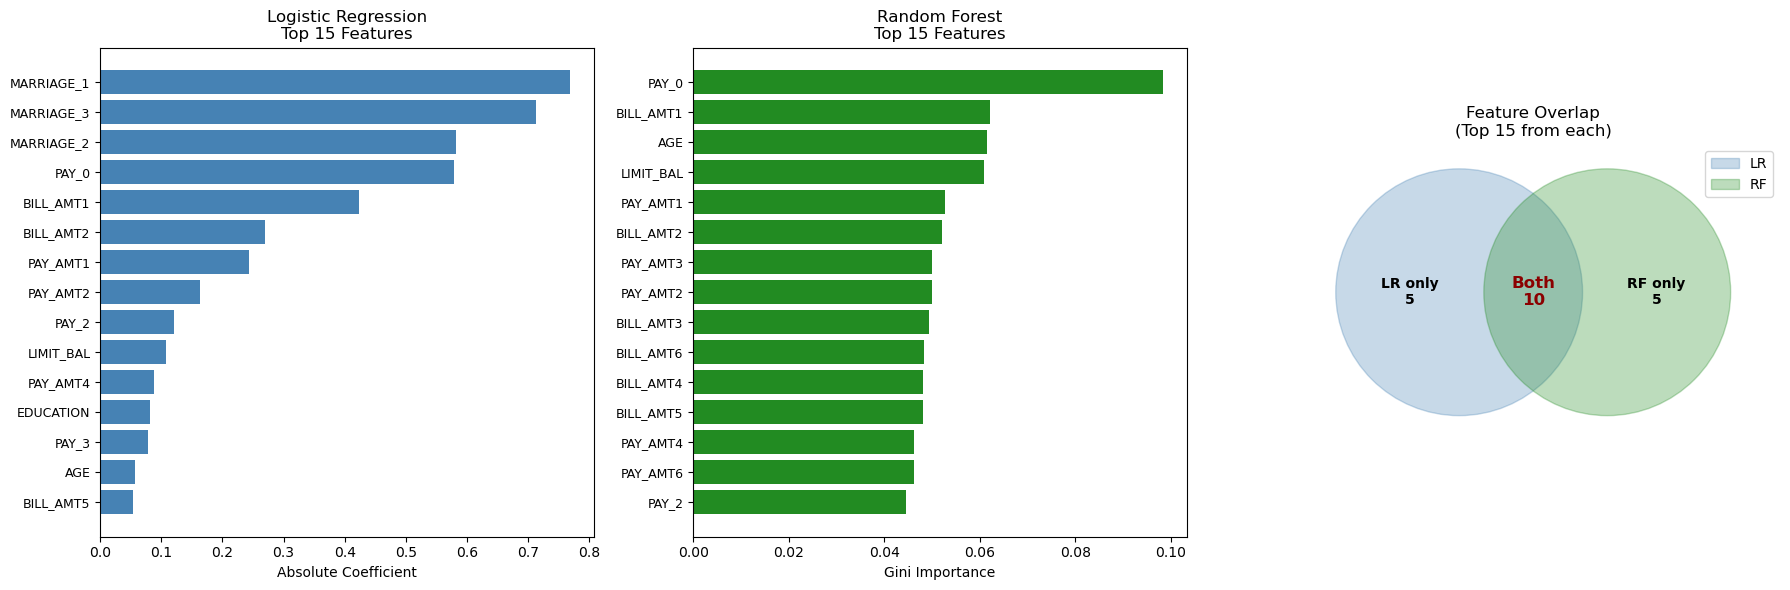

✓ FEATURE SELECTION COMPLETE
Original features: 25
Selected features (overlap): 10
Selected features (union): 20

New datasets created:
  X_train_selected: (23972, 10)
  X_test_selected: (5993, 10)

Selected features list:
['BILL_AMT2', 'PAY_AMT1', 'PAY_AMT2', 'BILL_AMT5', 'AGE', 'LIMIT_BAL', 'BILL_AMT1', 'PAY_0', 'PAY_AMT4', 'PAY_2']

Next step: Train your models on X_train_selected and X_test_selected


In [41]:
"""
Simple Feature Selection Using LR Coefficients + RF Feature Importance
Goal: Select the overlap/intersection of top features from both models
"""

# STEP 1: Get Feature Importance from Logistic Regression

# Get LR coefficients (absolute values)
lr_importance = pd.Series(
    np.abs(log_reg.coef_[0]), 
    index=X_train.columns
).sort_values(ascending=False)

print("="*70)
print("LOGISTIC REGRESSION - Top 20 Features")
print("="*70)
print(lr_importance.head(20))
print()

# STEP 2: Get Feature Importance from Random Forest

# Get RF feature importance
rf_importance = pd.Series(
    rf_clf.feature_importances_, 
    index=X_train.columns
).sort_values(ascending=False)

print("="*70)
print("RANDOM FOREST - Top 20 Features")
print("="*70)
print(rf_importance.head(20))
print()

# STEP 3: Select Top N Features from Each Model

# Choose how many top features to consider from each model
top_n = 15  # Can be adjusted  as needed

# Get top features from each model
top_lr_features = set(lr_importance.head(top_n).index)
top_rf_features = set(rf_importance.head(top_n).index)

print("="*70)
print(f"Top {top_n} features from Logistic Regression:")
print("="*70)
print(list(top_lr_features))
print()

print("="*70)
print(f"Top {top_n} features from Random Forest:")
print("="*70)
print(list(top_rf_features))
print()

# STEP 4: Get Overlap (Intersection) - Features Important in BOTH

# Features that appear in top N of BOTH models
selected_features_overlap = list(top_lr_features.intersection(top_rf_features))

print("="*70)
print(f"🎯 SELECTED FEATURES (Overlap - Top {top_n} from BOTH models)")
print("="*70)
print(f"Number of features: {len(selected_features_overlap)}")
print(selected_features_overlap)
print()

# OPTIONAL: We can also consider Union - Features Important in EITHER Model

# Features that appear in top N of EITHER model (more inclusive)
selected_features_union = list(top_lr_features.union(top_rf_features))

print("="*70)
print(f"ALTERNATIVE: Union (Top {top_n} from EITHER model)")
print("="*70)
print(f"Number of features: {len(selected_features_union)}")
print(selected_features_union)
print()

# STEP 5: Visualize the Selection

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# LR Top Features
top_lr_vis = lr_importance.head(15)
axes[0].barh(range(len(top_lr_vis)), top_lr_vis.values, color='steelblue')
axes[0].set_yticks(range(len(top_lr_vis)))
axes[0].set_yticklabels(top_lr_vis.index, fontsize=9)
axes[0].set_xlabel('Absolute Coefficient')
axes[0].set_title(f'Logistic Regression\nTop {len(top_lr_vis)} Features')
axes[0].invert_yaxis()

# RF Top Features
top_rf_vis = rf_importance.head(15)
axes[1].barh(range(len(top_rf_vis)), top_rf_vis.values, color='forestgreen')
axes[1].set_yticks(range(len(top_rf_vis)))
axes[1].set_yticklabels(top_rf_vis.index, fontsize=9)
axes[1].set_xlabel('Gini Importance')
axes[1].set_title(f'Random Forest\nTop {len(top_rf_vis)} Features')
axes[1].invert_yaxis()

# Venn Diagram Visualization (conceptual)
from matplotlib.patches import Circle
axes[2].set_xlim(0, 10)
axes[2].set_ylim(0, 10)
axes[2].set_aspect('equal')

# Draw circles
circle1 = Circle((3.5, 5), 2.5, color='steelblue', alpha=0.3, label='LR')
circle2 = Circle((6.5, 5), 2.5, color='forestgreen', alpha=0.3, label='RF')
axes[2].add_patch(circle1)
axes[2].add_patch(circle2)

# Add text
axes[2].text(2.5, 5, f'LR only\n{len(top_lr_features - top_rf_features)}', 
             ha='center', va='center', fontsize=10, weight='bold')
axes[2].text(7.5, 5, f'RF only\n{len(top_rf_features - top_lr_features)}', 
             ha='center', va='center', fontsize=10, weight='bold')
axes[2].text(5, 5, f'Both\n{len(selected_features_overlap)}', 
             ha='center', va='center', fontsize=12, weight='bold', color='darkred')

axes[2].set_xlim(0, 10)
axes[2].set_ylim(2, 8)
axes[2].axis('off')
axes[2].set_title(f'Feature Overlap\n(Top {top_n} from each)')
axes[2].legend(loc='upper right')

plt.tight_layout()
plt.show()


# STEP 6: Create Reduced Feature Sets

# Create new datasets with only selected features (OVERLAP)
X_train_selected = X_train[selected_features_overlap]
X_test_selected = X_test[selected_features_overlap]

print("="*70)
print("✓ FEATURE SELECTION COMPLETE")
print("="*70)
print(f"Original features: {X_train.shape[1]}")
print(f"Selected features (overlap): {X_train_selected.shape[1]}")
print(f"Selected features (union): {len(selected_features_union)}")
print()
print("New datasets created:")
print(f"  X_train_selected: {X_train_selected.shape}")
print(f"  X_test_selected: {X_test_selected.shape}")
print()
print("Selected features list:")
print(selected_features_overlap)
print()
print("="*70)
print("Next step: Train your models on X_train_selected and X_test_selected")  # ✅ CORRECTED
print("="*70)

## STEP 7 : Training Models


### Logistic Regression Without class balancing


In [42]:
log_reg = LogisticRegression(
    max_iter=1000, 
    random_state=100,    
)

# Train models
print("Training Logistic Regression...")
log_reg.fit(X_train, y_train)

def evaluate_model(model, X_val, y_val):
    """Evaluate model and return key metrics"""
    y_pred = model.predict(X_val)
    y_proba = model.predict_proba(X_val)[:, 1]
    
    accuracy = accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred, zero_division=0)
    recall = recall_score(y_val, y_pred, zero_division=0)
    f1 = f1_score(y_val, y_pred, zero_division=0)
    roc_auc = roc_auc_score(y_val, y_proba)
    
    return accuracy, precision, recall, f1, roc_auc

# Evaluate all models
log_reg_metrics = evaluate_model(log_reg, X_test, y_test)


# Display results
print("="*70)
print("BASELINE MODEL PERFORMANCE -  (Testing Dataset)")
print("="*70)
print(f"Logistic Regression - Accuracy: {log_reg_metrics[0]:.4f}, Precision: {log_reg_metrics[1]:.4f}, "
      f"Recall: {log_reg_metrics[2]:.4f}, F1: {log_reg_metrics[3]:.4f}, ROC-AUC: {log_reg_metrics[4]:.4f}")

print("="*70)

# LOWER RECALL VALUE

Training Logistic Regression...
BASELINE MODEL PERFORMANCE -  (Testing Dataset)
Logistic Regression - Accuracy: 0.8134, Precision: 0.7291, Recall: 0.2496, F1: 0.3719, ROC-AUC: 0.7161


### Training Logistic Regression, Decision Tree and SVM without class weights on the data


In [43]:
# Initialize models WITHOUT class_weight='balanced'(without feature impotance based selection)
log_reg = LogisticRegression(
    max_iter=1000, 
    random_state=100
)

dec_tree = DecisionTreeClassifier(
    random_state=100
)

svm = SVC(
    random_state=100,
    probability=True  # Needed for predict_proba
)

# Train models
print("Training Logistic Regression (unbalanced)...")
log_reg.fit(X_train, y_train)

print("Training Decision Tree (unbalanced)...")
dec_tree.fit(X_train, y_train)

print("Training SVM (unbalanced)...")
svm.fit(X_train, y_train)

print("✓ Baseline models trained successfully (without class balancing)!")

# CELL 8: Evaluate Models on Testing Data (Unbalanced)

"""
## Step 7: Evaluate Models (Without Balancing)

Metrics used:
- **Accuracy:** Overall correctness
- **Precision:** Of predicted defaults, how many are correct?
- **Recall:** Of actual defaults, how many did we catch?
- **F1-Score:** Harmonic mean of precision and recall (important for imbalanced data)
- **ROC-AUC:** Area under ROC curve (threshold-independent metric)

**Expected Issue:** Without balancing, models may have high accuracy but poor recall
(they'll predict "no default" too often).
"""

def evaluate_model(model, X_val, y_val):
    """Evaluate model and return key metrics"""
    y_pred = model.predict(X_val)
    y_proba = model.predict_proba(X_val)[:, 1]
    
    accuracy = accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred, zero_division=0)
    recall = recall_score(y_val, y_pred, zero_division=0)
    f1 = f1_score(y_val, y_pred, zero_division=0)
    roc_auc = roc_auc_score(y_val, y_proba)
    
    return accuracy, precision, recall, f1, roc_auc

# Evaluate all models
log_reg_metrics = evaluate_model(log_reg, X_test, y_test)
dec_tree_metrics = evaluate_model(dec_tree, X_test, y_test)
svm_metrics = evaluate_model(svm, X_test, y_test)

# Display results
print("="*70)
print("BASELINE MODEL PERFORMANCE - WITHOUT BALANCING (Validation Set)")
print("="*70)
print(f"Logistic Regression - Accuracy: {log_reg_metrics[0]:.4f}, Precision: {log_reg_metrics[1]:.4f}, "
      f"Recall: {log_reg_metrics[2]:.4f}, F1: {log_reg_metrics[3]:.4f}, ROC-AUC: {log_reg_metrics[4]:.4f}")
print(f"Decision Tree       - Accuracy: {dec_tree_metrics[0]:.4f}, Precision: {dec_tree_metrics[1]:.4f}, "
      f"Recall: {dec_tree_metrics[2]:.4f}, F1: {dec_tree_metrics[3]:.4f}, ROC-AUC: {dec_tree_metrics[4]:.4f}")
print(f"SVM                 - Accuracy: {svm_metrics[0]:.4f}, Precision: {svm_metrics[1]:.4f}, "
      f"Recall: {svm_metrics[2]:.4f}, F1: {svm_metrics[3]:.4f}, ROC-AUC: {svm_metrics[4]:.4f}")
print("="*70)

Training Logistic Regression (unbalanced)...
Training Decision Tree (unbalanced)...
Training SVM (unbalanced)...
✓ Baseline models trained successfully (without class balancing)!
BASELINE MODEL PERFORMANCE - WITHOUT BALANCING (Validation Set)
Logistic Regression - Accuracy: 0.8134, Precision: 0.7291, Recall: 0.2496, F1: 0.3719, ROC-AUC: 0.7161
Decision Tree       - Accuracy: 0.7215, Precision: 0.3774, Recall: 0.3982, F1: 0.3875, ROC-AUC: 0.6060
SVM                 - Accuracy: 0.8166, Precision: 0.6743, Recall: 0.3311, F1: 0.4441, ROC-AUC: 0.7176


- It can be seen the that the recall is less here even though Accuracy is high.


### Considering Only important features for Training


In [44]:
# Initialize models WITHOUT class_weight='balanced' with feature importance selected features
log_reg = LogisticRegression(
    max_iter=1000, 
    random_state=100
)

dec_tree = DecisionTreeClassifier(
    random_state=100
)

svm = SVC(
    random_state=100,
    probability=True  # Needed for predict_proba
)

# Train models
print("Training Logistic Regression (unbalanced)...")
log_reg.fit(X_train_selected, y_train)

print("Training Decision Tree (unbalanced)...")
dec_tree.fit(X_train_selected, y_train)

print("Training SVM (unbalanced)...")
svm.fit(X_train_selected, y_train)

print("✓ Baseline models trained successfully (without class balancing)!")

# =============================================================================
# Evaluate Models on test Set (Unbalanced)
# =============================================================================
"""
## Step 7: Evaluate Baseline Models (Without Balancing)

Metrics used:
- **Accuracy:** Overall correctness
- **Precision:** Of predicted defaults, how many are correct?
- **Recall:** Of actual defaults, how many did we catch?
- **F1-Score:** Harmonic mean of precision and recall (important for imbalanced data)
- **ROC-AUC:** Area under ROC curve (threshold-independent metric)

**Expected Issue:** Without balancing, models may have high accuracy but poor recall
(they'll predict "no default" too often).
"""

def evaluate_model(model, X_val, y_val):
    """Evaluate model and return key metrics"""
    y_pred = model.predict(X_val)
    y_proba = model.predict_proba(X_val)[:, 1]
    
    accuracy = accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred, zero_division=0)
    recall = recall_score(y_val, y_pred, zero_division=0)
    f1 = f1_score(y_val, y_pred, zero_division=0)
    roc_auc = roc_auc_score(y_val, y_proba)
    
    return accuracy, precision, recall, f1, roc_auc

# Evaluate all models
log_reg_metrics = evaluate_model(log_reg, X_test_selected, y_test)
dec_tree_metrics = evaluate_model(dec_tree, X_test_selected, y_test)
svm_metrics = evaluate_model(svm, X_test_selected, y_test)

# Display results
print("="*70)
print("BASELINE MODEL PERFORMANCE - WITHOUT BALANCING ")
print("="*70)
print(f"Logistic Regression - Accuracy: {log_reg_metrics[0]:.4f}, Precision: {log_reg_metrics[1]:.4f}, "
      f"Recall: {log_reg_metrics[2]:.4f}, F1: {log_reg_metrics[3]:.4f}, ROC-AUC: {log_reg_metrics[4]:.4f}")
print(f"Decision Tree       - Accuracy: {dec_tree_metrics[0]:.4f}, Precision: {dec_tree_metrics[1]:.4f}, "
      f"Recall: {dec_tree_metrics[2]:.4f}, F1: {dec_tree_metrics[3]:.4f}, ROC-AUC: {dec_tree_metrics[4]:.4f}")
print(f"SVM                 - Accuracy: {svm_metrics[0]:.4f}, Precision: {svm_metrics[1]:.4f}, "
      f"Recall: {svm_metrics[2]:.4f}, F1: {svm_metrics[3]:.4f}, ROC-AUC: {svm_metrics[4]:.4f}")
print("="*70)

Training Logistic Regression (unbalanced)...
Training Decision Tree (unbalanced)...
Training SVM (unbalanced)...
✓ Baseline models trained successfully (without class balancing)!
BASELINE MODEL PERFORMANCE - WITHOUT BALANCING 
Logistic Regression - Accuracy: 0.8089, Precision: 0.7007, Recall: 0.2383, F1: 0.3557, ROC-AUC: 0.7136
Decision Tree       - Accuracy: 0.7270, Precision: 0.3838, Recall: 0.3861, F1: 0.3850, ROC-AUC: 0.6060
SVM                 - Accuracy: 0.8156, Precision: 0.6895, Recall: 0.3032, F1: 0.4212, ROC-AUC: 0.7112


- Considering important features does not change much, but it reduces time and memory complexity of the training process.


## Step 7: Baseline Models Training


- Logistic Regression
- Decision Tree
- SVM with class weights on Feature Important Data


#### Logistic Regression with class weights and without feature importance


In [45]:
# balancing the classes using class_weight parameter in Logistic Regression
log_reg = LogisticRegression(
    max_iter=1000, 
    random_state=100,
    class_weight={0: 1.0, 1: 4.0} 
)

# Train models
print("Training Logistic Regression...")
log_reg.fit(X_train, y_train)

def evaluate_model(model, X_val, y_val):
    """Evaluate model and return key metrics"""
    y_pred = model.predict(X_val)
    y_proba = model.predict_proba(X_val)[:, 1]
    
    accuracy = accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred, zero_division=0)
    recall = recall_score(y_val, y_pred, zero_division=0)
    f1 = f1_score(y_val, y_pred, zero_division=0)
    roc_auc = roc_auc_score(y_val, y_proba)
    
    return accuracy, precision, recall, f1, roc_auc

# Evaluate all models
log_reg_metrics = evaluate_model(log_reg, X_test, y_test)


# Display results
print("="*70)
print("BASELINE MODEL PERFORMANCE -  (Test DataSet)")
print("="*70)
print(f"Logistic Regression - Accuracy: {log_reg_metrics[0]:.4f}, Precision: {log_reg_metrics[1]:.4f}, "
      f"Recall: {log_reg_metrics[2]:.4f}, F1: {log_reg_metrics[3]:.4f}, ROC-AUC: {log_reg_metrics[4]:.4f}")

print("="*70)


Training Logistic Regression...
BASELINE MODEL PERFORMANCE -  (Test DataSet)
Logistic Regression - Accuracy: 0.6242, Precision: 0.3322, Recall: 0.6916, F1: 0.4488, ROC-AUC: 0.7165


In [46]:
# Define Baseline & Cost-Sensitive Models

"""
We now define:
1. Baseline Logistic Regression (class_weight='balanced')
2. Cost-sensitive Logistic Regression (heavier penalty on default = 1)
3. Decision Tree (with class weights)
4. SVM  (with class weights)

We will evaluate them and then build a weighted soft-voting ensemble.
"""


# Baseline Logistic Regression (balanced)
log_reg_base = LogisticRegression(
    max_iter=1000,
    random_state=100,
    class_weight='balanced'   # balances minority/majority automatically
)

# Cost-sensitive Logistic Regression (manual weights)
# Give default class (1) higher weight than non-default (0)
log_reg_cost = LogisticRegression(
    max_iter=1000,
    random_state=100,
    class_weight={0: 1.0, 1: 3.0}  # we tried with 0:1,1:4 as well
)

# Decision Tree (cost-sensitive)
dec_tree_cost = DecisionTreeClassifier(
    random_state=100,
    class_weight={0: 1.0, 1: 3.0},  #  penalize misclassifying defaulters
    min_samples_split=20,
    min_samples_leaf=10
)

# SVM (cost-sensitive)
svm_cost = SVC(
    random_state=100,
    class_weight={0: 1.0, 1: 3.0},
    probability=True 
     # needed for predict_proba and ROC
)

print("✓ Models defined (baseline LR, cost-sensitive LR, DT, SVM)")


✓ Models defined (baseline LR, cost-sensitive LR, DT, SVM)


#### STEP 8 :Evaluation for All models


In [47]:

#  Helper Function for Evaluation

"""
We will use one function to compute:
- Accuracy
- Precision
- Recall
- F1-Score
- ROC-AUC
and print a nice summary.
"""


def evaluate_model(name, model, X_val, y_val):
    """predict on validation, and print metrics."""
    y_pred = model.predict(X_val)
    y_proba = model.predict_proba(X_val)[:, 1]

    acc  = accuracy_score(y_val, y_pred)
    prec = precision_score(y_val, y_pred)
    rec  = recall_score(y_val, y_pred)
    f1   = f1_score(y_val, y_pred)
    auc  = roc_auc_score(y_val, y_proba)

    print(f"\n=== {name} ===")
    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1-Score : {f1:.4f}")
    print(f"AUC-ROC  : {auc:.4f}")
    print("Confusion Matrix:")
    print(confusion_matrix(y_val, y_pred))

    return acc, prec, rec, f1, auc


In [48]:
"""
Train:
- Logistic Regression (baseline)
- Logistic Regression (cost-sensitive)
- Decision Tree (cost-sensitive)
- SVM (cost-sensitive)

Evaluate all on test set.
"""

# Fit models
print("Training baseline Logistic Regression...")
log_reg_base.fit(X_train_selected, y_train)

print("Training cost-sensitive Logistic Regression...")
log_reg_cost.fit(X_train_selected, y_train)

print("Training cost-sensitive Decision Tree...")
dec_tree_cost.fit(X_train_selected, y_train)

print("Training cost-sensitive SVM...")
svm_cost.fit(X_train_selected, y_train)

# Evaluate on validation set
results_list = []

metrics_lr_base = evaluate_model("Logistic Regression (baseline)",       log_reg_base, X_test_selected, y_test)
metrics_lr_cost = evaluate_model("Logistic Regression (cost-sensitive)", log_reg_cost, X_test_selected, y_test)
metrics_dt_cost = evaluate_model("Decision Tree (cost-sensitive)",       dec_tree_cost, X_test_selected, y_test)
metrics_svm_cost = evaluate_model("SVM (RBF, cost-sensitive)",           svm_cost, X_test_selected, y_test)

results_list.append(("Logistic Regression (baseline)",)       + metrics_lr_base)
results_list.append(("Logistic Regression (cost-sensitive)",) + metrics_lr_cost)
results_list.append(("Decision Tree (cost-sensitive)",)       + metrics_dt_cost)
results_list.append(("SVM (RBF, cost-sensitive)",)            + metrics_svm_cost)

# Build a nice DataFrame for comparison
results_df = pd.DataFrame(
    results_list,
    columns=["Model", "Accuracy", "Precision", "Recall", "F1-Score", "ROC-AUC"]
)

print("\n" + "="*80)
print("INDIVIDUAL MODEL PERFORMANCE (Validation Set)")
print("="*80)
print(results_df.to_string(index=False))
print("="*80)


Training baseline Logistic Regression...
Training cost-sensitive Logistic Regression...
Training cost-sensitive Decision Tree...
Training cost-sensitive SVM...

=== Logistic Regression (baseline) ===
Accuracy : 0.6900
Precision: 0.3782
Recall   : 0.6229
F1-Score : 0.4707
AUC-ROC  : 0.7137
Confusion Matrix:
[[3309 1358]
 [ 500  826]]

=== Logistic Regression (cost-sensitive) ===
Accuracy : 0.7621
Precision: 0.4662
Recall   : 0.5204
F1-Score : 0.4918
AUC-ROC  : 0.7137
Confusion Matrix:
[[3877  790]
 [ 636  690]]

=== Decision Tree (cost-sensitive) ===
Accuracy : 0.6995
Precision: 0.3806
Recall   : 0.5709
F1-Score : 0.4567
AUC-ROC  : 0.7050
Confusion Matrix:
[[3435 1232]
 [ 569  757]]

=== SVM (RBF, cost-sensitive) ===
Accuracy : 0.7847
Precision: 0.5139
Recall   : 0.5023
F1-Score : 0.5080
AUC-ROC  : 0.7420
Confusion Matrix:
[[4037  630]
 [ 660  666]]

INDIVIDUAL MODEL PERFORMANCE (Validation Set)
                               Model  Accuracy  Precision   Recall  F1-Score  ROC-AUC
      

### Ensemble of Logistic Regression, Decision Tree and SVM


In [49]:
# Weighted Soft-Voting Ensemble (LR_cost + DT + SVM)

"""
We now create a *novel ensemble* by combining:
- Cost-sensitive Logistic Regression
- Cost-sensitive Decision Tree
- Cost-sensitive SVM

We use:
- Soft voting (average predicted probabilities)
- Weights to slightly favor SVM (stable + interpretable)
"""

ensemble_clf = VotingClassifier(
    estimators=[
        ('lr_cost', log_reg_cost),
        ('dt_cost', dec_tree_cost),
        ('svm_cost', svm_cost)
    ],
    voting='soft',
    weights=[2, 2, 4],   # we experimented with [2,1,1], [4,2,2], etc.
    n_jobs=-1
)

# random forest classifier 
rf_baseline = RandomForestClassifier(
    n_estimators=100,
    random_state=100,
    class_weight='balanced'
)
# random forest with class weights
rf_weighted = RandomForestClassifier(
    n_estimators=100,
    random_state=100,
    class_weight={0: 1.0, 1: 3.0}
)

print("Training weighted soft-voting ensemble...")
ensemble_clf.fit(X_train_selected, y_train)
# random forest training
rf_baseline.fit(X_train_selected, y_train)
# random forest with class weights
rf_weighted.fit( X_train_selected, y_train)

ensemble_metrics = evaluate_model("Ensemble (LR_cost + DT + SVM)", ensemble_clf, X_test_selected, y_test)
rf_metrics = evaluate_model("Random Forest", rf_baseline, X_test_selected, y_test)
rf_weighted_metrics = evaluate_model("Random Forest (cost-sensitive)", rf_weighted, X_test_selected, y_test)


Training weighted soft-voting ensemble...

=== Ensemble (LR_cost + DT + SVM) ===
Accuracy : 0.8013
Precision: 0.5631
Recall   : 0.4540
F1-Score : 0.5027
AUC-ROC  : 0.7421
Confusion Matrix:
[[4200  467]
 [ 724  602]]

=== Random Forest ===
Accuracy : 0.8066
Precision: 0.6165
Recall   : 0.3333
F1-Score : 0.4327
AUC-ROC  : 0.7445
Confusion Matrix:
[[4392  275]
 [ 884  442]]

=== Random Forest (cost-sensitive) ===
Accuracy : 0.8063
Precision: 0.6126
Recall   : 0.3386
F1-Score : 0.4361
AUC-ROC  : 0.7425
Confusion Matrix:
[[4383  284]
 [ 877  449]]


## STEP 9: Models Comparison For Final Usage


In [50]:

# Add ensemble and RF results to previous results_df
new_results = [
    ("Ensemble (LR_cost + DT + SVM)",) + ensemble_metrics,
    ("Random Forest (baseline)",) + rf_metrics,
    ("Random Forest (cost-sensitive)",) + rf_weighted_metrics
]

# Create DataFrame for new results
new_results_df = pd.DataFrame(
    new_results,
    columns=["Model", "Accuracy", "Precision", "Recall", "F1-Score", "ROC-AUC"]
)

# Combine all results
results_df = pd.concat([results_df, new_results_df], ignore_index=True)

print("\n" + "="*90)
print("FINAL MODEL COMPARISON (Test Set)")
print("="*90)
print(results_df.sort_values("ROC-AUC", ascending=False).to_string(index=False))
print("="*90)


FINAL MODEL COMPARISON (Test Set)
                               Model  Accuracy  Precision   Recall  F1-Score  ROC-AUC
            Random Forest (baseline)  0.806608   0.616457 0.333333  0.432697 0.744523
      Random Forest (cost-sensitive)  0.806274   0.612551 0.338612  0.436134 0.742467
       Ensemble (LR_cost + DT + SVM)  0.801268   0.563143 0.453997  0.502714 0.742094
           SVM (RBF, cost-sensitive)  0.784749   0.513889 0.502262  0.508009 0.742041
      Logistic Regression (baseline)  0.689972   0.378205 0.622926  0.470655 0.713672
Logistic Regression (cost-sensitive)  0.762056   0.466216 0.520362  0.491803 0.713663
      Decision Tree (cost-sensitive)  0.699483   0.380593 0.570890  0.456712 0.705020


In [51]:

# Final Comparison Table (Including Ensemble)


#NOTE: NOT REQUIRED CELL, REMOVE IF NOT NEEDED.

# Add ensemble results to previous results_df
results_df = pd.concat([
    results_df,
    pd.DataFrame([("Ensemble (LR_cost + DT + SVM)",) + ensemble_metrics],
                 columns=["Model", "Accuracy", "Precision", "Recall", "F1-Score", "ROC-AUC"])
], ignore_index=True)

print("\n" + "="*90)
print("FINAL MODEL COMPARISON (Validation Set)")
print("="*90)
print(results_df.sort_values("ROC-AUC", ascending=False).to_string(index=False))
print("="*90)



FINAL MODEL COMPARISON (Validation Set)
                               Model  Accuracy  Precision   Recall  F1-Score  ROC-AUC
            Random Forest (baseline)  0.806608   0.616457 0.333333  0.432697 0.744523
      Random Forest (cost-sensitive)  0.806274   0.612551 0.338612  0.436134 0.742467
       Ensemble (LR_cost + DT + SVM)  0.801268   0.563143 0.453997  0.502714 0.742094
       Ensemble (LR_cost + DT + SVM)  0.801268   0.563143 0.453997  0.502714 0.742094
           SVM (RBF, cost-sensitive)  0.784749   0.513889 0.502262  0.508009 0.742041
      Logistic Regression (baseline)  0.689972   0.378205 0.622926  0.470655 0.713672
Logistic Regression (cost-sensitive)  0.762056   0.466216 0.520362  0.491803 0.713663
      Decision Tree (cost-sensitive)  0.699483   0.380593 0.570890  0.456712 0.705020


### ROC-AUC Curve for all models in single graph


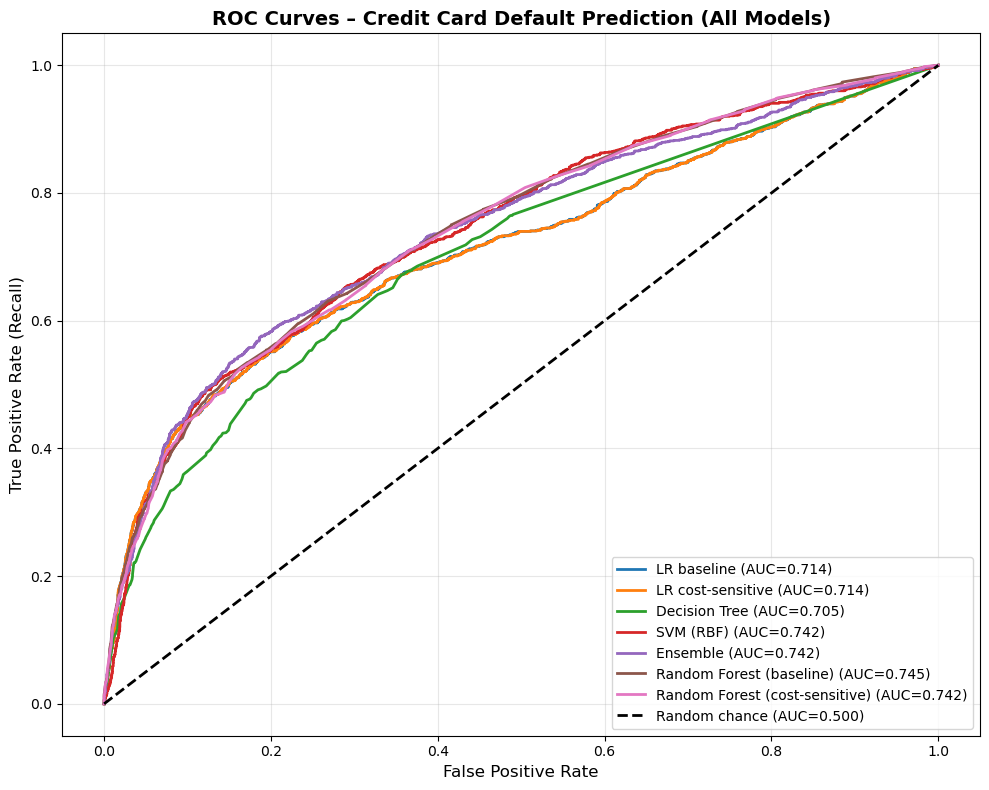

ROC-AUC Summary:
LR baseline                             : AUC = 0.7137
LR cost-sensitive                       : AUC = 0.7137
Decision Tree                           : AUC = 0.7050
SVM (RBF)                               : AUC = 0.7420
Ensemble                                : AUC = 0.7421
Random Forest (baseline)                : AUC = 0.7445
Random Forest (cost-sensitive)          : AUC = 0.7425


In [54]:
#  ROC Curves for All Models

plt.figure(figsize=(10, 8))

# All models to plot
models_for_roc = [
    ("LR baseline", log_reg_base),
    ("LR cost-sensitive", log_reg_cost),
    ("Decision Tree", dec_tree_cost),
    ("SVM (RBF)", svm_cost),
    ("Ensemble", ensemble_clf),
    ("Random Forest (baseline)", rf_baseline),
    ("Random Forest (cost-sensitive)", rf_weighted)
]

# Plot ROC curve for each model
for name, model in models_for_roc:
    y_proba = model.predict_proba(X_test_selected)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    auc_val = auc(fpr, tpr)
    plt.plot(fpr, tpr, linewidth=2, label=f"{name} (AUC={auc_val:.3f})")

# Plot random chance baseline
plt.plot([0, 1], [0, 1], 'k--', linewidth=2, label='Random chance (AUC=0.500)')

plt.xlabel("False Positive Rate", fontsize=12)
plt.ylabel("True Positive Rate (Recall)", fontsize=12)
plt.title("ROC Curves – Credit Card Default Prediction (All Models)", fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("="*70)
print("ROC-AUC Summary:")
print("="*70)
for name, model in models_for_roc:
    y_proba = model.predict_proba(X_test_selected)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    auc_val = auc(fpr, tpr)
    print(f"{name:40s}: AUC = {auc_val:.4f}")
print("="*70)

### CONFUSION MATRIX


Best Precision Model: Random Forest (baseline)
Precision: 0.6165

Best Recall Model: Logistic Regression (baseline)
Recall: 0.6229


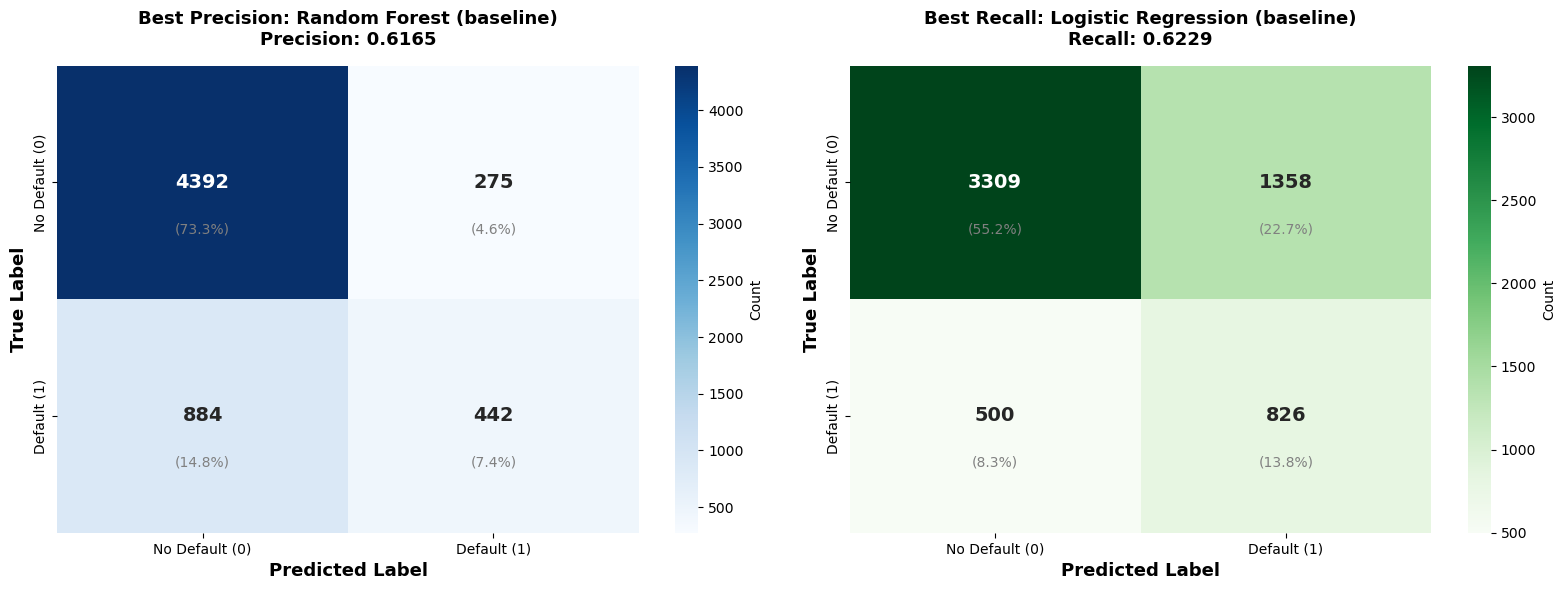


DETAILED CONFUSION MATRIX ANALYSIS

📊 Random Forest (baseline) (Best Precision)
----------------------------------------------------------------------
True Negatives (TN):   4392 - Correctly predicted NO default
False Positives (FP):   275 - Incorrectly predicted default (Type I Error)
False Negatives (FN):   884 - Missed actual defaults (Type II Error) ⚠️
True Positives (TP):    442 - Correctly caught defaults ✓

Precision = TP/(TP+FP) = 442/717 = 0.6165
Recall    = TP/(TP+FN) = 442/1326 = 0.3333

📊 Logistic Regression (baseline) (Best Recall)
----------------------------------------------------------------------
True Negatives (TN):   3309 - Correctly predicted NO default
False Positives (FP):  1358 - Incorrectly predicted default (Type I Error)
False Negatives (FN):   500 - Missed actual defaults (Type II Error) ⚠️
True Positives (TP):    826 - Correctly caught defaults ✓

Precision = TP/(TP+FP) = 826/2184 = 0.3782
Recall    = TP/(TP+FN) = 826/1326 = 0.6229

💡 INTERPRETATION
Best P

In [55]:

# Confusion Matrices for Best Precision & Best Recall Models

# Find best models
best_precision_idx = results_df['Precision'].idxmax()
best_recall_idx = results_df['Recall'].idxmax()

best_precision_model = results_df.loc[best_precision_idx, 'Model']
best_recall_model = results_df.loc[best_recall_idx, 'Model']

print("="*70)
print(f"Best Precision Model: {best_precision_model}")
print(f"Precision: {results_df.loc[best_precision_idx, 'Precision']:.4f}")
print()
print(f"Best Recall Model: {best_recall_model}")
print(f"Recall: {results_df.loc[best_recall_idx, 'Recall']:.4f}")
print("="*70)

# Map model names to actual model objects
model_mapping = {
    "Logistic Regression (baseline)": log_reg_base,
    "Logistic Regression (cost-sensitive)": log_reg_cost,
    "Decision Tree (cost-sensitive)": dec_tree_cost,
    "SVM (RBF, cost-sensitive)": svm_cost,
    "Ensemble (LR_cost + DT + SVM)": ensemble_clf,
    "Random Forest (baseline)": rf_baseline,
    "Random Forest (cost-sensitive)": rf_weighted
}

# Get predictions
best_prec_model_obj = model_mapping[best_precision_model]
best_recall_model_obj = model_mapping[best_recall_model]

y_pred_precision = best_prec_model_obj.predict(X_test_selected)
y_pred_recall = best_recall_model_obj.predict(X_test_selected)

# Create confusion matrices
cm_precision = confusion_matrix(y_test, y_pred_precision)
cm_recall = confusion_matrix(y_test, y_pred_recall)

# Plot confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Confusion Matrix 1: Best Precision
sns.heatmap(cm_precision, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No Default (0)', 'Default (1)'],
            yticklabels=['No Default (0)', 'Default (1)'],
            cbar_kws={'label': 'Count'},
            annot_kws={'size': 14, 'weight': 'bold'},
            ax=axes[0])
axes[0].set_xlabel('Predicted Label', fontsize=13, fontweight='bold')
axes[0].set_ylabel('True Label', fontsize=13, fontweight='bold')
axes[0].set_title(f'Best Precision: {best_precision_model}\nPrecision: {results_df.loc[best_precision_idx, "Precision"]:.4f}', 
                  fontsize=13, fontweight='bold', pad=15)

# Add percentage annotations
total = cm_precision.sum()
for i in range(2):
    for j in range(2):
        pct = (cm_precision[i, j] / total) * 100
        axes[0].text(j + 0.5, i + 0.7, f'({pct:.1f}%)', 
                    ha='center', va='center', fontsize=10, color='gray')

# Confusion Matrix 2: Best Recall
sns.heatmap(cm_recall, annot=True, fmt='d', cmap='Greens', 
            xticklabels=['No Default (0)', 'Default (1)'],
            yticklabels=['No Default (0)', 'Default (1)'],
            cbar_kws={'label': 'Count'},
            annot_kws={'size': 14, 'weight': 'bold'},
            ax=axes[1])
axes[1].set_xlabel('Predicted Label', fontsize=13, fontweight='bold')
axes[1].set_ylabel('True Label', fontsize=13, fontweight='bold')
axes[1].set_title(f'Best Recall: {best_recall_model}\nRecall: {results_df.loc[best_recall_idx, "Recall"]:.4f}', 
                  fontsize=13, fontweight='bold', pad=15)

# Add percentage annotations
total = cm_recall.sum()
for i in range(2):
    for j in range(2):
        pct = (cm_recall[i, j] / total) * 100
        axes[1].text(j + 0.5, i + 0.7, f'({pct:.1f}%)', 
                    ha='center', va='center', fontsize=10, color='gray')

plt.tight_layout()
plt.show()

# Detailed breakdown
print("\n" + "="*70)
print("DETAILED CONFUSION MATRIX ANALYSIS")
print("="*70)

print(f"\n📊 {best_precision_model} (Best Precision)")
print("-" * 70)
tn_p, fp_p, fn_p, tp_p = cm_precision.ravel()
print(f"True Negatives (TN):  {tn_p:5d} - Correctly predicted NO default")
print(f"False Positives (FP): {fp_p:5d} - Incorrectly predicted default (Type I Error)")
print(f"False Negatives (FN): {fn_p:5d} - Missed actual defaults (Type II Error) ⚠️")
print(f"True Positives (TP):  {tp_p:5d} - Correctly caught defaults ✓")
print(f"\nPrecision = TP/(TP+FP) = {tp_p}/{tp_p+fp_p} = {tp_p/(tp_p+fp_p):.4f}")
print(f"Recall    = TP/(TP+FN) = {tp_p}/{tp_p+fn_p} = {tp_p/(tp_p+fn_p):.4f}")

print(f"\n📊 {best_recall_model} (Best Recall)")
print("-" * 70)
tn_r, fp_r, fn_r, tp_r = cm_recall.ravel()
print(f"True Negatives (TN):  {tn_r:5d} - Correctly predicted NO default")
print(f"False Positives (FP): {fp_r:5d} - Incorrectly predicted default (Type I Error)")
print(f"False Negatives (FN): {fn_r:5d} - Missed actual defaults (Type II Error) ⚠️")
print(f"True Positives (TP):  {tp_r:5d} - Correctly caught defaults ✓")
print(f"\nPrecision = TP/(TP+FP) = {tp_r}/{tp_r+fp_r} = {tp_r/(tp_r+fp_r):.4f}")
print(f"Recall    = TP/(TP+FN) = {tp_r}/{tp_r+fn_r} = {tp_r/(tp_r+fn_r):.4f}")

print("\n" + "="*70)
print("💡 INTERPRETATION")
print("="*70)
print(f"Best Precision Model catches {tp_p} defaults with {fp_p} false alarms")
print(f"Best Recall Model catches {tp_r} defaults with {fp_r} false alarms")
print(f"\nRecall improvement: +{tp_r - tp_p} more defaults caught")
print(f"False Positive increase: +{fp_r - fp_p} more false alarms")
print("="*70)

### Conclusion:

This project successfully developed machine learning models to predict credit
card defaults using the dataset (30,000 clients, 25 features).
